<a href="https://colab.research.google.com/github/PlantInGreenhouse/DS_TermProject_9/blob/main/modeling_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('termproject/preprocessed_data_standard_iqr.csv')

# Separate features and target
X = data.drop(columns=['salary_in_usd'])
y = data['salary_in_usd']

# Convert target to categorical for classification
y_class = pd.qcut(y, q=3, labels=[0, 1, 2])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Function to find the best k value for k-fold cross-validation
def find_best_k(X, y, model, k_range):
    best_k = None
    best_score = 0
    for k in k_range:
        cv = KFold(n_splits=k, shuffle=True, random_state=42)
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        avg_score = np.mean(scores)
        if avg_score > best_score:
            best_score = avg_score
            best_k = k
    return best_k

# Define the RandomForestClassifier model
rfc = RandomForestClassifier(random_state=42)

# Find the best k value
k_range = range(2, 11)
best_k = find_best_k(X_train, y_train, rfc, k_range)
print(f"Best k: {best_k}")

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Define the cross-validation strategy with the best k
cv = KFold(n_splits=best_k, shuffle=True, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_rfc = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Predict on the test set using the best model
y_pred = best_rfc.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Classification Report:")
print(class_report)

Best k: 5
Best parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}
Accuracy: 0.5263870094722598
Precision: 0.508700462044154
Recall: 0.5263870094722598
F1 Score: 0.48713605726860704
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.60      0.61       232
           1       0.40      0.16      0.23       248
           2       0.50      0.81      0.62       259

    accuracy                           0.53       739
   macro avg       0.51      0.52      0.49       739
weighted avg       0.51      0.53      0.49       739



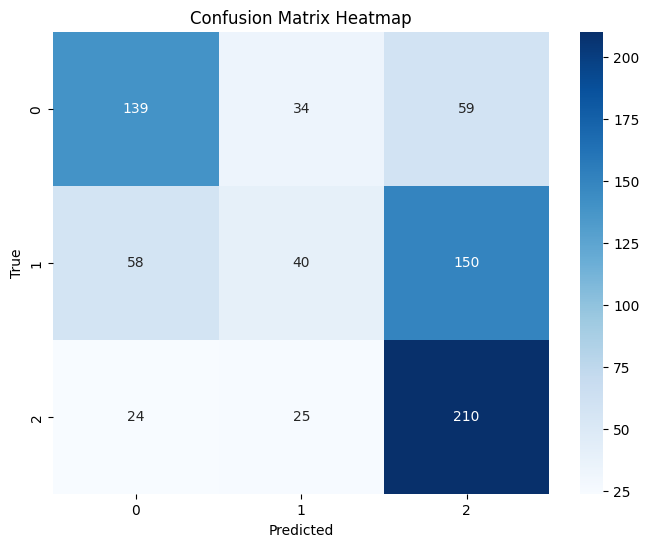

In [9]:
# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

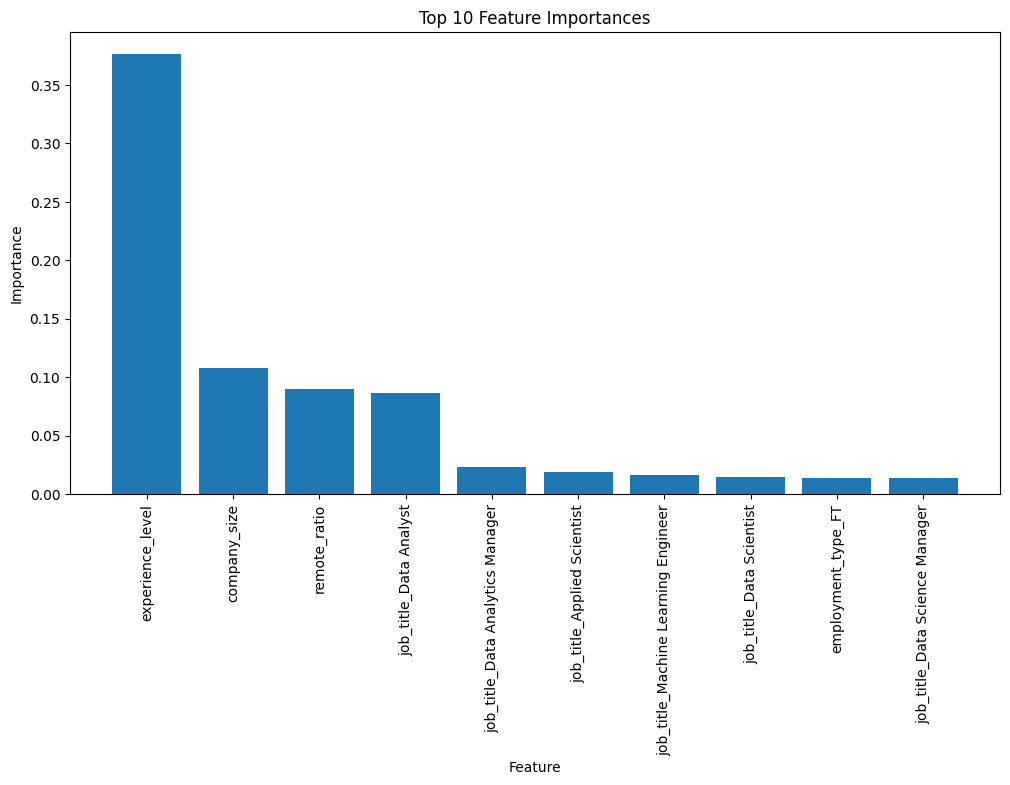

In [10]:
# Plot feature importance
feature_importances = best_rfc.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Top 10 Feature Importances")
plt.bar(range(10), feature_importances[indices][:10], align='center')
plt.xticks(range(10), features[indices][:10], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()